<center>
    <a href="https://rapids.ai/"><img width='80%' src='https://raw.githubusercontent.com/miroenev/rapids/master/rapids_workflow.png'></a></center>    


<h1>RAPIDS Demo - End-To-End ML Workflow</h1>
by Miro Enev

> 1. Motivate rapids [ show coverage of modern data science tools ]

> 2. Generate a synthetic dataset
    * 2.1 - Split into train and test set
    * 2.2 - Visualize sub-datasets

> 3. ETL
    * 3.1 - Load data [ csv read ]     
    * 3.2 - Transform data [ standard scaler ]

> 4. Model Building 
    * 4.1 - Train CPU and GPU XGBoost classifier models 
    * 4.2 - Use trained models for inference
    * 4.3 - Compare accuracy
    * 4.4 - Visualize sample boosted trees & model predictions

> 5. Extensions 
    * 5.1 - Create an ensemble with a clustering model [ DBScan ]
    * 5.2 - Export data to DeepLearning Framework [ PyTorch ]
    


#### **Note**: for interactive 3D plots using ipyvolume, change the flag below to False 
> ```useMatplotlib3DFlag``` = ~~```True```~~ ```False```

In [1]:
import pandas as pd, numpy as np, sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.metrics import confusion_matrix, accuracy_score

import xgboost
from xgboost import plot_tree

import cuml, cudf, numba, scipy
from numba import cuda 
import time

useMatplotlib3DFlag = True # False 
if useMatplotlib3DFlag:
    from mpl_toolkits.mplot3d import Axes3D
else:
    import ipyvolume as ipv

from ipywidgets import interact   
import matplotlib.pyplot as plt
from fig_helpers import *


------
# 1. Motivation: Kaggle [2018](https://www.kaggle.com/surveys/2018) and [2017](https://www.kaggle.com/surveys/2017) Data Science Surveys
<center>
   <table>
   <tr>
       <td width="25%">
           <h2>RAPIDS accelerates datascience: </h2>
           <ul>
               <li><h3>it maps to core datascience tasks</h3></li>
               <li><h3>covers popular methods</h3></li>
               <li><h3>delivers on dataset sizes typically used</h3></li>
               <li><h3>uses familiar python API</h3></li>
           </ul>
       </td>
       <td><img src='https://storage.googleapis.com/kaggle-datasets-images/70947/156853/3ef5dd03338ef20b7c6118e4ed600a87/dataset-cover.jpg?t=2018-11-05-19-24-06'></td>
   </tr>
   </table>
    
</center>


In [2]:
# use the dropdown below to browse through Kaggle survey results 
interact(display_selected_figure, figure_choice=['activity breakdown', 'datasize', 'methods used', 'language used']);

interactive(children=(Dropdown(description='figure_choice', options=('activity breakdown', 'datasize', 'method…

-----
# 2. Generate Dataset [ X: features, y: labels ]

Set the size of the generated dataset -- the number of total samples is determined by this value

In [3]:
nTotalSamples = 5000000

Next we'll use <a href='https://scikit-learn.org/stable/datasets/index.html#generated-datasets'>sklearn.datasets</a> to build synthetic sub-datasets of the size we specified above. We'll build three sub-datasets and combine them together and then use a trained model to see if we can determine which of sub-dataset a sample belongs to. The three sub-datasets are built using the moons, blobs, and swiss-roll generators. These sub-datasets were selected for their distinct visual features.

In [4]:
%%time
nSamplesPerSubDataset = nTotalSamples//3

swissRollDataset = datasets.make_swiss_roll( n_samples = nSamplesPerSubDataset, noise = .005)[0]

moonsDataset = datasets.make_moons(n_samples = nSamplesPerSubDataset, noise = 0)[0]
moonsDataset = np.hstack( [moonsDataset, np.zeros( (moonsDataset.shape[0], 1) )] )*4

blobsDataset = datasets.make_blobs( n_samples = nSamplesPerSubDataset, centers = 5,  n_features = 3, 
                                    cluster_std = 0.25,  random_state = 0)[0] + [0, 1.5, 0]

CPU times: user 1.09 s, sys: 156 ms, total: 1.25 s
Wall time: 1.25 s


In [5]:
X = np.vstack([blobsDataset, swissRollDataset, moonsDataset])

In [6]:
# generate labels for classification 
blobsLabels = np.zeros(blobsDataset.shape[0])
moonsLabels = 1 * np.ones(moonsDataset.shape[0])
sRollLabels = 2 * np.ones(swissRollDataset.shape[0])

y = np.hstack( [blobsLabels, sRollLabels, moonsLabels])

In [7]:
X.shape, y.shape

((4999998, 3), (4999998,))

## 2.1 - Split Train (75%) and Test (25%) Data 
We split our combined dataset into two portions:
* **train-set** - which we'll use to optimize our model's parameters [ train-set = randomly selected 75% of total data]
* **test-set** - which we'll use to evaluate how well our trained model performs on unseen data [ test-set = remaining 25% of data ]

In [8]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.25, random_state = 0, shuffle=True)

In [9]:
len(X_train), len(X_test)

(3749998, 1250000)

## 2.2 - Visualize Data
We define a function for plotting using either matplotlib Axes3D [ default ] or  <a href='https://github.com/maartenbreddels/ipyvolume'>ipyvolume</a> for WebGL based 3D plotting -- we restrict the maximum points to plot to `maxSamplesToPlot` which has a default setting of `100000`

In [10]:
def mpl_plot_data( data, colorStack = 'purple', 
                  maxSamplesToPlot = 10000, 
                  ax3D = False, markerScale=1):
    
    nSamplesToPlot = np.min( ( len(data), maxSamplesToPlot ) )
    if not ax3D:ax3D = plt.figure(figsize=(12,12)).gca(projection='3d')
            
    if isinstance(colorStack, np.ndarray):
        colorStack = colorStack[0:maxSamplesToPlot,:]
        
    ax3D.scatter(data[0:nSamplesToPlot,0], 
                 data[0:nSamplesToPlot,1], 
                 data[0:nSamplesToPlot,2], s = 20*markerScale, c=colorStack, depthshade=False)
    
    ax3D.view_init(elev=10, azim=95)
    
def ipv_plot_data( data, colorStack = 'purple', 
                  maxSamplesToPlot = 100000, 
                  holdOnFlag = False, markerSize=.5):
    
    nSamplesToPlot = np.min( ( len(data), maxSamplesToPlot ) )
    if not holdOnFlag: ipv.figure(width=600,height=600)
        
    if isinstance(colorStack, np.ndarray):
        colorStack = colorStack[0:maxSamplesToPlot,:]

    ipv.scatter( data[0:nSamplesToPlot,0], 
                 data[0:nSamplesToPlot,1], 
                 data[0:nSamplesToPlot,2], size = markerSize, 
                 marker = 'sphere', color = colorStack)
    
    if not holdOnFlag: ipv.show()    

In [11]:
if useMatplotlib3DFlag:
    plot_data = mpl_plot_data
else:
    plot_data = ipv_plot_data    

## Sub-Datasets [ moons, blobs, swiss-roll ] 

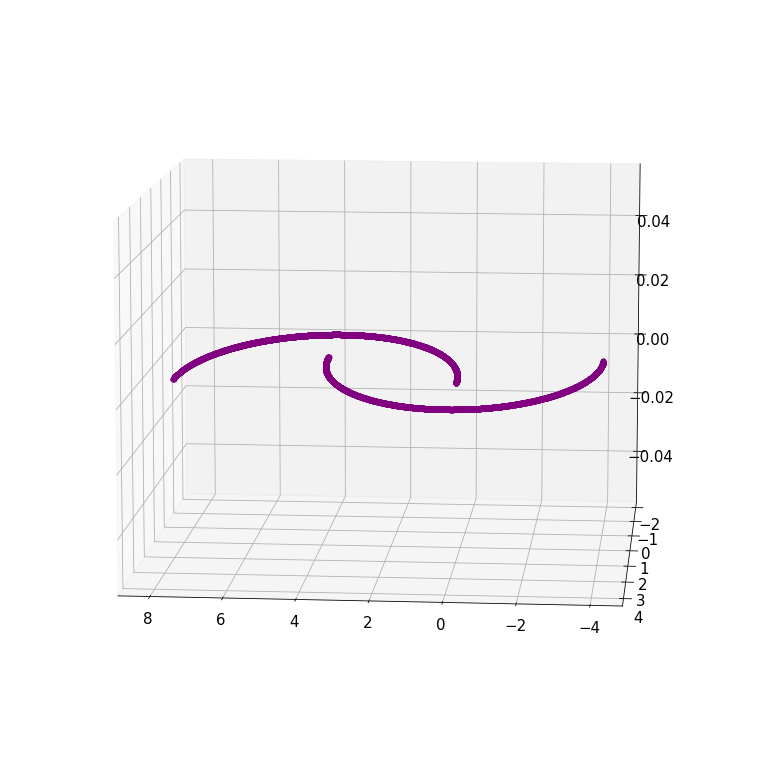

In [12]:
plot_data( moonsDataset)

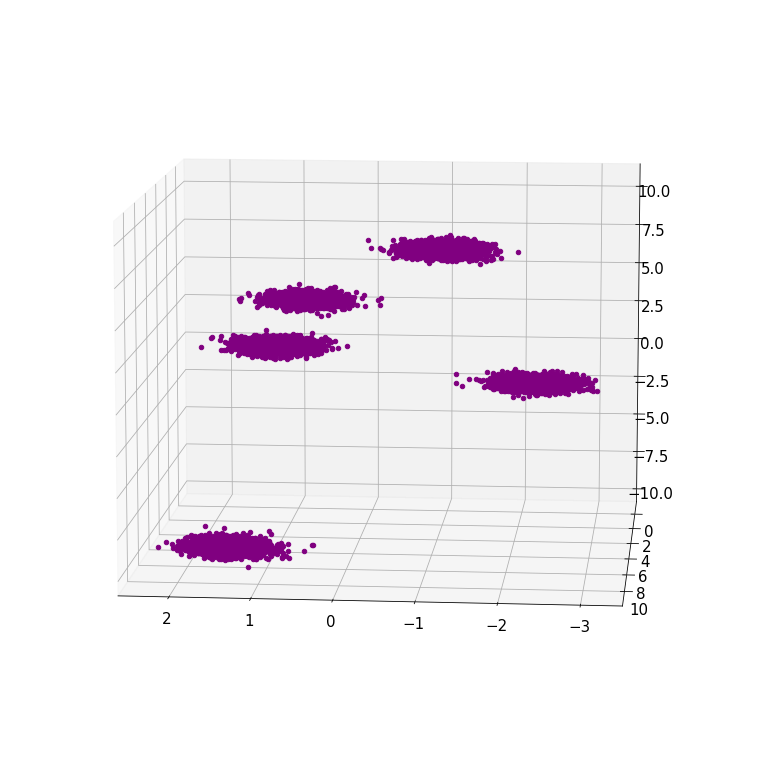

In [13]:
plot_data( blobsDataset )

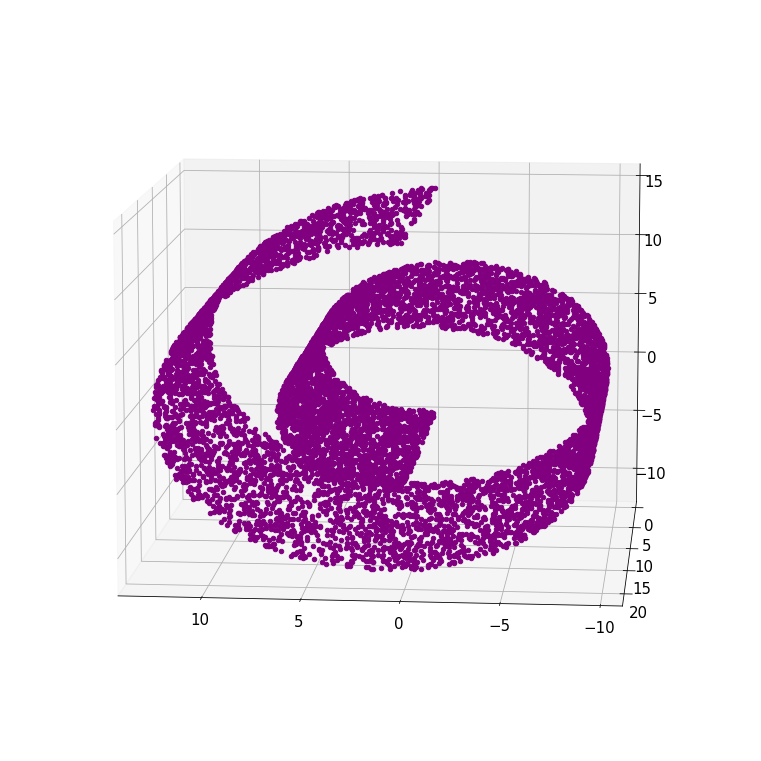

In [14]:
plot_data( swissRollDataset )

## Combined Dataset Plot
The train-set is shown in purple and the test-set is show in yellow.

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


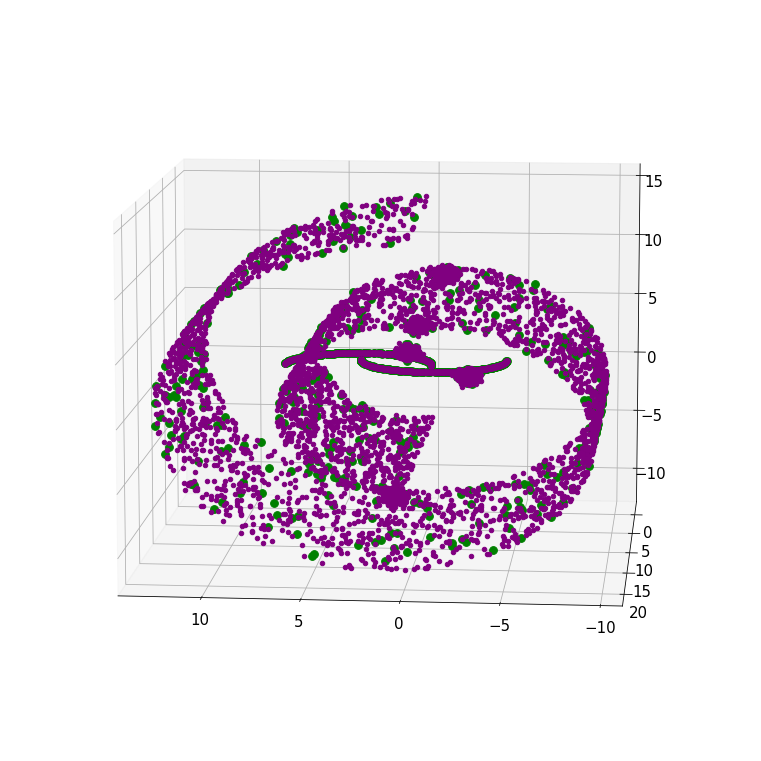

In [15]:
%time
if useMatplotlib3DFlag: 
    ax3D = plt.figure(figsize=(12,12)).gca(projection='3d')
    plot_data( X_train, 'purple', 10000, ax3D)
    plot_data( X_test, 'green', 1000, ax3D, 3)
else:
    ipv.figure()
    ipv_plot_data( X_train, 'purple', 100000, True)
    ipv_plot_data( X_test, 'green', 1000, True, 1.5)
    ipv.show()

------
# 3. ETL 
First we write the dataset to disk (as a comma separated file - CSV) so that we can subsequently demonstrate data loading.

In [16]:
%%time
pd.DataFrame(data = X_train).to_csv('X_train.csv.txt', index = False)
pd.DataFrame(data = X_test).to_csv('X_test.csv.txt', index = False)
pd.DataFrame(data = y_train).to_csv('y_train.csv.txt', index = False)
pd.DataFrame(data = y_test).to_csv('y_test.csv.txt', index = False)

CPU times: user 25.9 s, sys: 246 ms, total: 26.1 s
Wall time: 26.4 s


In [17]:
!echo 'no data\n0' > warmup.csv # write a mini csv file used to initialize cuIO kernels

## Check Size of Data on Disk 
using the default value of `nTotalSamples = 5000000` should produce a training set of `~184MBs` in size.

In [18]:
!du -h *csv.txt *.gzip

62M	X_test.csv.txt
184M	X_train.csv.txt
4.8M	y_test.csv.txt
15M	y_train.csv.txt
du: cannot access '*.gzip': No such file or directory


# 3.1 - Load Data

In [19]:
%%time 
startTime = time.time()

pd_X_train = pd.read_csv('X_train.csv.txt',  delimiter=',')
pd_X_test = pd.read_csv('X_test.csv.txt',  delimiter=',')
pd_y_train = pd.read_csv('y_train.csv.txt',  delimiter=',')
pd_y_test = pd.read_csv('y_test.csv.txt',  delimiter=',')

pandasIngestionTime = time.time() - startTime

CPU times: user 2.11 s, sys: 196 ms, total: 2.31 s
Wall time: 2.31 s


In [20]:
# get column-names
f = open('X_train.csv.txt'); colNames = f.readline().strip().split(','); f.close()
# warmup rapids data ingestion engines [ cuio kernels ]
cudf.read_csv('warmup.csv')

,no data
0,0


In [21]:
%%time
startTime = time.time()

cudf_X_train = cudf.read_csv('X_train.csv.txt', delimiter=',', skiprows=1, names=colNames, dtype=['float64', 'float64', 'float64'])
cudf_X_test = cudf.read_csv('X_test.csv.txt', delimiter=',', skiprows=1, names=colNames, dtype=['float64', 'float64', 'float64'])
cudf_y_train = cudf.read_csv('y_train.csv.txt', dtype=['float64'])
cudf_y_test = cudf.read_csv('y_test.csv.txt', dtype=['float64'])

rapidsIngestionTime = time.time() - startTime

CPU times: user 144 ms, sys: 39.7 ms, total: 184 ms
Wall time: 183 ms


## Evaluate Load/Ingestion Speedup

In [22]:
pandasIngestionTime/rapidsIngestionTime

12.643155568723627

# 3.2 - Transform Data ( Normalize )
Transforming a dataset is a common requirement prior to training upstream models. For each feature in the dataset we remove the mean and divide by the standard deviation -- this makes each feature behave like a normally distributed variable (e.g. gaussian with 0 mean and unit variance). 

For the data on the CPU we can use the pre-built <a href='https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html'>sklearn.preprocessing.StandardScaler</a> function.
In the case of the GPU, we demonstrate how the same transformation can be built using a custom (user defined) function written as a <a href='http://numba.pydata.org/numba-doc/0.13/CUDAJit.html'>just-in-time numba kernel</a>. 

Note that we compute the mean and standard deviation statistics on the training data, and then apply the transformation to the training and test data (i.e., the test data is never seen when computing the mean & standard deviation).

In [23]:
%%time 
startTime = time.time()

scaler = sklearn.preprocessing.StandardScaler().fit(pd_X_train) # normalize
pd_X_train = scaler.transform(pd_X_train)
pd_X_test = scaler.transform(pd_X_test)

pandasTransformTime = time.time() - startTime 

CPU times: user 187 ms, sys: 71.9 ms, total: 259 ms
Wall time: 258 ms


-----

In [24]:
@cuda.jit 
def gpu_scale(outputCol, colGPUArrays, colMeans, colStDevs):
    iRow = cuda.grid(1)
    if iRow < colGPUArrays.size:
        outputCol[iRow] = ( colGPUArrays[iRow] - colMeans ) / ( colStDevs + 1e-10 )

In [25]:
def standard_scaler_numba( targetDF, trainMeans = None, trainStdevs = None):
    nRows = targetDF.shape[0]
    
    blockSize = 128
    blockCount = nRows // blockSize + 1
    scaledDF = cudf.DataFrame()
    
    if trainMeans is None and trainStdevs is None:
        trainMeans = {}
        trainStdevs = {}
        
    for iColName in targetDF.columns:
        colGPUArray = targetDF[iColName].to_gpu_array()
        outputCol = cuda.device_array ( shape=(nRows), dtype=colGPUArray.dtype.name)       
        if iColName not in trainMeans.keys():
            trainMeans[iColName] = targetDF[iColName].mean()
        if iColName not in trainStdevs.keys():
            trainStdevs[iColName] = targetDF[iColName].std()
        gpu_scale[(blockCount),(blockSize)](outputCol, colGPUArray, trainMeans[iColName], trainStdevs[iColName])
#       scaledDF.add_column(name=iColName, data = outputCol)            
        scaledDF[iColName] = outputCol
    return scaledDF, trainMeans, trainStdevs

In [26]:
_, _, _ = standard_scaler_numba( cudf_X_test.copy().head(2) ) # warmup


In [27]:
%%time
startTime = time.time()

cudf_X_train, trainMeans, trainStdevs = standard_scaler_numba( cudf_X_train )
cudf_X_test, _, _ = standard_scaler_numba( cudf_X_test, trainMeans, trainStdevs )

rapidsTransformTime = time.time() - startTime

CPU times: user 21.5 ms, sys: 12.1 ms, total: 33.6 ms
Wall time: 32.5 ms


## Evaluate Transform Speedup

In [28]:
pandasTransformTime/rapidsTransformTime

7.9545788191080185

## Verify [approximate] numerical equivalence between CPU and GPU

In [29]:
trainMeans, scaler.mean_, trainStdevs, scaler.scale_

({'0': 1.3101929901549607, '1': 5.997005213014613, '2': 0.48577644835383904},
 array([1.31019299, 5.99700521, 0.48577645]),
 {'0': 4.504008680849348, '1': 5.746398789388324, '2': 5.236134271509409},
 array([4.50400808, 5.74639802, 5.23613357]))

In [30]:
print(pd_X_test[0:2,:])

[[-0.77245017 -0.45873789 -0.09277388]
 [-0.92294425  1.7209442  -2.06783678]]


In [31]:
print(cudf_X_test.head(2))

          0         1         2
0 -0.772450 -0.458738 -0.092774
1 -0.922944  1.720944 -2.067837


-----
# 4. - Model Building with XGBoost
-----
XGBoost is a popular algorithm for classification. It uses a sequence of decision trees built in succession such that each new tree attempts to correct the errors made by its predecessors (analogy to multiple golf swings [ each improving on the past ] to reach a target). For a deeper dive into how XGBoost works check out the following dev blog: <br>
> https://devblogs.nvidia.com/gradient-boosting-decision-trees-xgboost-cuda/

<img src='https://raw.githubusercontent.com/miroenev/rapids/master/xgboost.png' width =90%>
<center> img src: https://explained.ai/gradient-boosting/L2-loss.html </center>

## Prepare Data for Training

In [32]:
X = pd_X_train
y = pd_y_train

In [33]:
train_DataAndLabelsGPU = xgboost.DMatrix(pd_X_train, label=np.squeeze(pd_y_train))
test_DataAndLabelsGPU = xgboost.DMatrix(pd_X_test, label=np.squeeze(pd_y_test))

## Specify Model Parameters

noteable parameters: [ to see all available options execute '?xgboost.XGBClassifier' in a new cell] 

* __max_depth__ : int [ CPU default = 3, GPU default = 6 ] -- Maximum tree depth for base learners.
* __n_trees/estimators__ : int [ CPU default = 100, GPU default = 10 ] -- Number of boosted trees to fit.
* __n_GPUs__ : default is 1 GPU, set to -1 to use all GPUs
    
  
<font color=red>**Note :**</font> For apples to apples comparison, `cpuMaxDepth` is set to the same as `gpuMaxDepth`.
This will result in a large processing time on CPU.
If you wish to work faster, it is recommended to set `cpuMaxDepth` to its default value.

In [34]:
'''key CPU PARAMS '''
cpuMaxDepth = 6
cpuNTrees = 100

In [35]:
'''key GPU PARAMS '''
# number of GPUs to utilize -- we typically need > 10GB datasets to benefit from multiple GPUs
nGPUs = 1 # default is 1 GPU, set to -1 to use all GPUs 

# GPU multiple shallow trees [ default ] 
gpuMaxDepth = 6; 
gpuNTrees = 10; 

# GPU few/one deep trees [ experiment with this setting for faster training with comparable accuracy ]
# gpuMaxDepth = 15; 
# gpuNTrees = 1 

In [36]:
nCores = !nproc --all
nCores = int(nCores[0])

paramsGPU = {
    'max_depth': gpuMaxDepth,
    'num_boost_rounds': gpuNTrees,    
    'objective': 'multi:softmax',
    'num_class': 3,
    'tree_method': 'gpu_hist',
    'random_state': 0,
    'n_gpus': nGPUs
}

In [37]:
paramsCPU = {
    'max_depth': cpuMaxDepth,
    'n_estimators': cpuNTrees,
    'tree_method': 'hist',
    'objective': 'multi:softmax',
    'num_class': 3,
    'n_jobs': nCores
}

-----
# 4.1 - Model Training

## Train on **CPU**

In [38]:
xgBoostModelCPU = xgboost.XGBClassifier(max_depth = paramsCPU['max_depth'], 
                                        n_estimators = paramsCPU['n_estimators'],
                                        tree_method = paramsCPU['tree_method'],
                                        objective = paramsCPU['objective'],
                                        num_class = paramsCPU['num_class'],
                                        n_jobs = paramsCPU['n_jobs'])

In [39]:
xgBoostModelCPU, print("using {} CPU cores for parallel xgboost training".format(nCores))

using 4 CPU cores for parallel xgboost training


(XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=None, max_delta_step=None, max_depth=6,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=4, num_class=3, num_parallel_tree=None,
               objective='multi:softmax', random_state=None, reg_alpha=None,
               reg_lambda=None, scale_pos_weight=None, subsample=None,
               tree_method='hist', validate_parameters=None, verbosity=None),
 None)

In [40]:
%%time
startTime = time.time()

xgBoostModelCPU.fit( X, y );

cpuXGBoostTime = time.time() - startTime

/opt/conda/envs/rapids/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[08:39:25] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1612969829206/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 3min 27s, sys: 277 ms, total: 3min 28s
Wall time: 52.8 s


## Train on **GPU**

In [41]:
%%time
startTime = time.time()

xgBoostModelGPU = xgboost.train( dtrain = train_DataAndLabelsGPU, params = paramsGPU, num_boost_round = gpuNTrees )

gpuXGBoostTime = time.time() - startTime

[08:40:16] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1612969829206/work/include/xgboost/generic_parameters.h:39: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.
[08:40:16] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1612969829206/work/src/learner.cc:541: 
Parameters: { num_boost_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:40:16] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1612969829206/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if 

## Evaluate Training Speedup

In [42]:
cpuXGBoostTime/gpuXGBoostTime

23.99961744672488

-----
# 4.2 - Model Inference

## Infer/predict using Trained **CPU** Model

In [43]:
%%time
startTime = time.time()

yPredTrainCPU = xgBoostModelCPU.predict(pd_X_train)
yPredTestCPU = xgBoostModelCPU.predict(pd_X_test)

cpuXGBoostInferenceTime = time.time() - startTime

CPU times: user 40.3 s, sys: 108 ms, total: 40.4 s
Wall time: 10.4 s


## Infer/predict using Trained **GPU** Model
> note that our objective was changed to a regression [ gpu accelerated ] so we must take care to convert each of our predictions from a continuous value to a discrete class (essentially by rounding).

In [44]:
%%time
startTime = time.time()
yPredTrainGPU = xgBoostModelGPU.predict(train_DataAndLabelsGPU)
yPredTestGPU = xgBoostModelGPU.predict(test_DataAndLabelsGPU)
gpuXGBoostInferenceTime = time.time() - startTime


[08:40:28] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1612969829206/work/include/xgboost/generic_parameters.h:39: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.
CPU times: user 1.25 s, sys: 6 µs, total: 1.25 s
Wall time: 363 ms


## Evaluate Inference Speedup

In [45]:
cpuXGBoostInferenceTime/gpuXGBoostInferenceTime

28.803101451219785

-----
# 4.3 - Evaluate Accuracy
# note: for binary classification problems consider using AUC 
> from sklearn.metrics import roc_auc_score

> roc_auc_score( pd_y_test.values, np.expand_dims(yPredTestCPU,1) )


In [46]:
print( 'CPU test accuracy: {0:.6f} '.format( accuracy_score(pd_y_test, yPredTestCPU) ))
print( 'GPU test accuracy: {0:.6f} '.format( accuracy_score(pd_y_test, yPredTestGPU) ))

CPU test accuracy: 0.999960 
GPU test accuracy: 0.999894 


TODO: to increase model accuracy, increase complexity, number of trees, max_depth


In [47]:
print('\n confusion matrix on TRAIN data -- ')
print(confusion_matrix(pd_y_train, yPredTrainCPU))
print('\n confusion matrix on TEST data -- ')
print( confusion_matrix(pd_y_test, yPredTestCPU))


 confusion matrix on TRAIN data -- 
[[1249998       0      57]
 [      0 1250225       0]
 [     10       0 1249708]]

 confusion matrix on TEST data -- 
[[416581      0     30]
 [     0 416441      0]
 [    20      0 416928]]


In [48]:
print('\n confusion matrix on TRAIN data -- ')
print(confusion_matrix(pd_y_train, yPredTrainGPU))
print('\n confusion matrix on TEST data -- ')
print( confusion_matrix(pd_y_test, yPredTestGPU))


 confusion matrix on TRAIN data -- 
[[1249693       0     362]
 [      0 1250225       0]
 [      0      10 1249708]]

 confusion matrix on TEST data -- 
[[416485      0    126]
 [     0 416441      0]
 [     0      7 416941]]


# 4.4 - Visualize Model Outputs

## Visualizing a CPU boosted tree

ImportError: You must install graphviz to plot tree

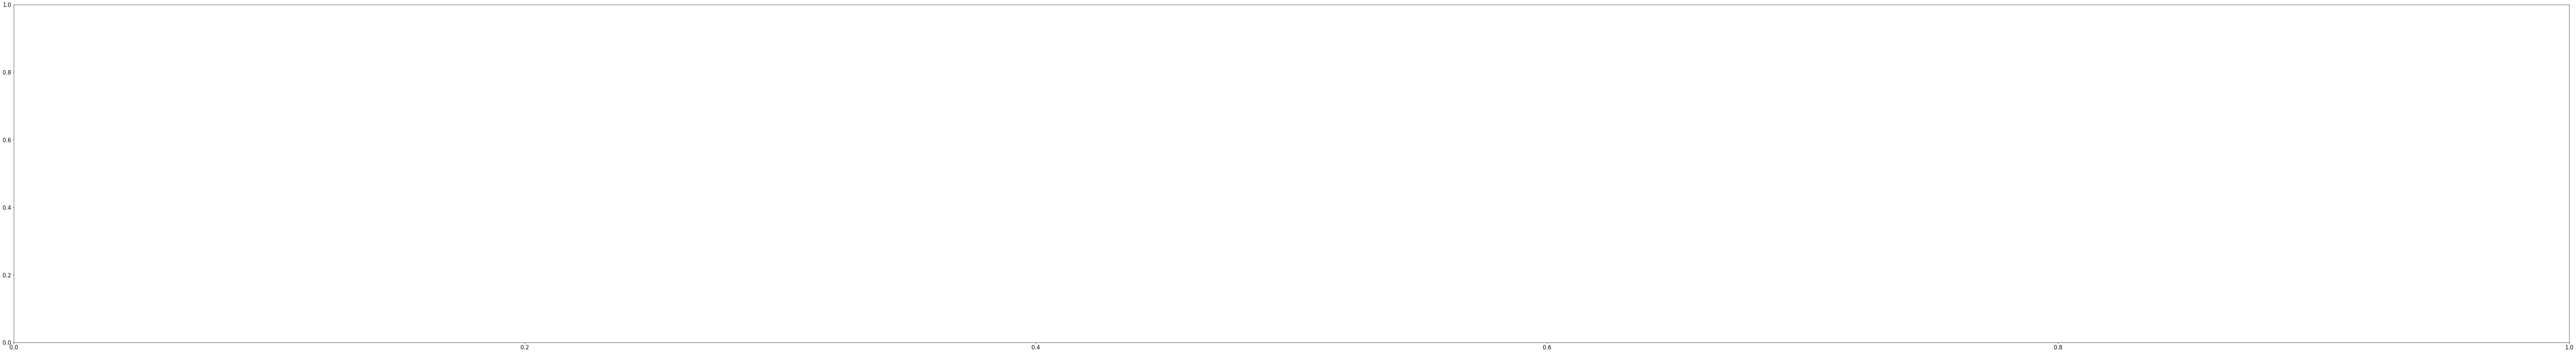

In [49]:
fig = plt.figure(figsize=(100,15))
plot_tree(xgBoostModelCPU, num_trees=0, ax=plt.subplot(1,1,1))

## Visualizing a GPU Boosted Tree

In [ ]:
fig = plt.figure(figsize=(100,50))
plot_tree(xgBoostModelGPU, num_trees=0, ax=plt.subplot(1,1,1))

## Visualize Class Predictions

In [ ]:
def map_colors_to_clusters_topK ( dataset, labels, topK=None, cmapName = 'tab10'):
    if topK == None:
        topK = dataset.shape[0]
    
    colorStack = np.zeros((topK, 3), dtype=np.float32)
    
    cMap = plt.get_cmap(cmapName)
    for iColor in range ( topK ):
        colorStack[iColor] = cMap.colors[ labels[iColor] ]
        
    return colorStack    

In [ ]:
colorStackClassifier = map_colors_to_clusters_topK ( pd_X_test, yPredTestGPU.astype(np.int), topK=None )

In [ ]:
plot_data( pd_X_test, colorStack= colorStackClassifier)

-------
# Extensions
-------
For extensions to this work visit <a href="https://github.com/miroenev/rapids">github.com/miroenev/rapids</a>

-----
# End [ thanks! ]